In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Cumulant4_fonction import C4_long, C4_court, Cross_time
from DoubleRigidWallOverdampedBrownExp_Cython import RigidWallOverdampedLangevin3D
from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz

import csv
from multiprocessing import Pool
import itertools


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm
# axes.xaxis.set_tick_params(direction='in', which='both')
# axes.yaxis.set_tick_params(direction='in', which='both')


mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1
mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc

rc("font", family="serif")
rc("text", usetex=False)
rc("xtick", labelsize="medium")
rc("ytick", labelsize="medium")
rc("axes", labelsize="large")

# Model de diffusion dans un canal étroit 

Code origine : $\mathrm{\color{red}{Cumulant4\_fonction.py}}$ et  $\mathrm{\color{red}{DoubleRigidWallOverdampedBrownExp\_Cython.pyx}}$

Auteur : $\mathrm{\color{purple}{Élodie ~MILLAN}}$

Date : 14/01/2022


- $2H_p$ : hauteur du canal;
- $a$ : rayon de la particule;
- On pose $H = H_p -a$
- $\eta_0$ : viscosité du fluide
- $D_\|(z) = \frac{k_\mathrm{B}T}{6 \pi \eta_\| a}$ : coeficient de diffusion colinéaire au mur, avec $\eta_\| (z) = \eta_0 \left( 1 - \frac{9a}{16(z+a)} +  \left( \frac{a}{8(z+a)} \right)^3 - \left( \frac{45a}{256(z+a)} \right)^4 - \left( \frac{a}{16(z+a)} \right)^5 \right)^{-1}$. 
- $D_\perp(z) = \frac{k_\mathrm{B}T}{6 \pi \eta_\perp a}$ : coeficient de diffusion transverse au mur, avec $\eta_\perp(z) = \eta_0 \frac{6z^2 + 9az + 2a^2}{6z^2 + 2az}$.


Les viscosités effectives du fluide, transverse et colinaires, dû à la présence des deux mur s'écrivent : $\eta_\mathrm{eff} = \eta_\mathrm{B} + \eta_\mathrm{T} - \eta_0$, où le mur du bas est placé en $-H_\mathrm{P}$ et le mur du haut est en $+H_\mathrm{P}$. Les deux murs sont donc distant de $2 H_\mathrm{P}$.

La particule est soumise au poids et à la répulstion electronique des deux mur, donc le potentiel vaud :

\begin{equation}
    V = B k_\mathrm{B}T \left( \exp \left( -\frac{z_\mathrm{B}}{l_\mathrm{D}} \right) + \exp \left( -\frac{z_\mathrm{T}}{l_\mathrm{D}} \right)  \right) + \frac{k_\mathrm{B} T }{l_\mathrm{B}}z = B k_\mathrm{B}T \left( \exp \left( -\frac{(H+z)}{l_\mathrm{D}} \right) + \exp \left( -\frac{(H-z)}{l_\mathrm{D}} \right)  \right) + \frac{k_\mathrm{B} T }{l_\mathrm{B}}z.
\end{equation}
avec $z_\mathrm{B} = H+z$ la distance entre la particule (en $z$) et le mur du bas ; et $z_\mathrm{T} = H-z$, celle entre la particule et le mur du haut.

La force électrostatique vaud alors :
\begin{equation}
    F_\mathrm{elec} = -\frac{\partial V_\mathrm{elec}}{\partial z} = \frac{B k_\mathrm{B}T }{l_\mathrm{D}} e^{- \frac{H}{l_\mathrm{D}}} \left( \exp \left( -\frac{z}{l_\mathrm{D}} \right) - \exp \left( \frac{z}{l_\mathrm{D}} \right)  \right),
\end{equation}
et la force gravitaire :
\begin{equation}
    F_\mathrm{grav} = -\frac{k_\mathrm{B} T }{l_\mathrm{B}}.
\end{equation}

La PDF de $z$ s'écrit alors :
\begin{equation}
    P_\mathrm{eq}(z) = \frac{1}{N} \exp \left( -\frac{V}{k_\mathrm{B}T} \right) = \frac{1}{N} e^{ - B  \left( \exp \left( -\frac{(H+z)}{l_\mathrm{D}} \right) + \exp \left( -\frac{(H-z)}{l_\mathrm{D}} \right)  \right) - \frac{z}{l_\mathrm{B}}},
\end{equation}

\begin{equation}
    P_\mathrm{eq}(z) = \frac{1}{N} e^{ - B \exp \left( -\frac{H}{l_\mathrm{D}} \right) \left \{ \exp \left( -\frac{z}{l_\mathrm{D}} \right) + \exp \left( +\frac{z}{l_\mathrm{D}} \right)  \right \} - \frac{z}{l_\mathrm{B}}}.
\end{equation}

Le spurious drift s'écrit :
\begin{equation}
    F_\mathrm{spurious} = k_\mathrm{B}T \frac{D_{\perp,\mathrm{eff}} '(z)}{D_{\perp,\mathrm{eff}}(z)} = D_{\perp,\mathrm{eff}} '(z) \gamma_{\perp,\mathrm{eff}}(z) = - \frac{k_\mathrm{B}T (\eta_\mathrm{B}'(z) + \eta_\mathrm{T}'(z))}{6 \pi a (\eta_\mathrm{B}(z) + \eta_\mathrm{T}(z) - \eta_0)^2} \gamma_{\perp,\mathrm{eff}}(z)
\end{equation}
avec :
\begin{equation}
    \eta_\mathrm{eff,\perp}'(z) = \eta_\mathrm{B}'(z) + \eta_\mathrm{T}'(z) = \eta_0 \left( \frac{a}{(H-z)^2} - \frac{a}{(H+z)^2} - \frac{3(8a-9)}{2(a+3H-3z)^2} + \frac{3(8a-9)}{2(a+3H+3z)^2}  \right) 
\end{equation}


$\mathrm{B}=\mathrm{Bottom}$, $\mathrm{T}=\mathrm{Top}$

Équation de Langevin overdamped:
\begin{equation}
   \gamma_\mathrm{eff} (z) \frac{\mathrm{d}z}{\mathrm{d}t} = F_\mathrm{grav} + F_\mathrm{elec} - F_\mathrm{spurious} + w(z) \frac{\mathrm{d}B_t}{\mathrm{d}t}
\end{equation}

\begin{equation}
   z_{i+1} = z_i + \left( F_\mathrm{grav} + F_\mathrm{elec} - F_\mathrm{spurious} + w(z) \frac{\mathrm{d}B_t} {\mathrm{d}t} \right) \frac{\mathrm{d}t}{\gamma_\mathrm{eff}(z)}
\end{equation}

\begin{equation}
   z_{i+1} = z_i + \left( F_\mathrm{grav} + F_\mathrm{elec} \right) \frac{\mathrm{d}t}{\gamma_\mathrm{eff} (z)} - D_\mathrm{eff,\perp}' \mathrm{d}t  + w(z) \mathrm{RNG} \mathrm{d}t.
\end{equation}


In [2]:
dt = 1e-3
Nt = 1000000
Nt_sub = 100 #Ntotale = Nt*Nt_sub

a = 1.5e-6
H = 2e-6
lD = 68.0e-9
lB = 565.0e-9
kBT=1.38e-23*300
B=4.8
eta=0.001

zz = np.linspace(-H+H*1e-3, H-H*1e-3, 1000)


In [3]:

F_elec = lambda z: B * kBT/lD * np.exp(-H/lD) * (np.exp(-z/lD) - np.exp(z/lD))
F_grav = lambda z: - kBT/lB*np.ones(len(z))

P_eq = lambda z: np.exp(-B*np.exp(-H/lD)*(np.exp(-z/lD) + np.exp(z/lD)) - z/lB)



def gamma_z_eff(zi_1, a, eta, H):
    """
    Formule de Padé
    """
    # Mur Top
    gam_z = (
        6
        * np.pi
        * a
        * eta
        * (
            (
                (6 * (H-zi_1)**2 + 9*a*(H-zi_1) + 2*a**2)
                / (6 * (H-zi_1)**2 + 2*a*(H-zi_1))
            )
        )
    )
    # Mur Bottom
    gam_z_2 = (
        6
        * np.pi
        * a
        * eta
        * (
            (
                (6 * (H+zi_1)**2 + 9*a*(H+zi_1) + 2*a**2)
                / (6 * (H+zi_1)**2 + 2*a*(H+zi_1))
            )
        )
    )

    gam_z_0 = 6 * np.pi * a * eta

    return (gam_z + gam_z_2 - gam_z_0)

def gamma_xy_eff(zi_1, a, eta, H):
    """
    Formule de Libshaber
    """
    # Mur Top
    gam_xy_T = (
        6
        * np.pi
        * a
        * eta
        * (
            1
            - ((9 * a) / (16 * ((H-zi_1) + a)))
            + (a / (8 * ((H-zi_1) + a))) ** 3
            - (45 * a / (256 * ((H-zi_1) + a))) ** 4
            - (a / (16 * ((H-zi_1) + a))) ** 5
        )
        ** (-1)
    )

    gam_xy_B = (
        6
        * np.pi
        * a
        * eta
        * (
            1
            - ((9 * a) / (16 * ((H+zi_1) + a)))
            + (a / (8 * ((H+zi_1) + a))) ** 3
            - (45 * a / (256 * ((H+zi_1) + a))) ** 4
            - (a / (16 * ((H+zi_1) + a))) ** 5
        )
        ** (-1)
    )

    gam_xy_0 = 6 * np.pi * a * eta

    return (gam_xy_T + gam_xy_B - gam_xy_0)


def Dprime_z_eff(zi, kBT, eta, a, H):
    # Spurious force pour corriger overdamping (Auteur: Dr. Maxime Lavaud)
    eta_B = lambda zi: eta * (6*(H+zi)**2 + 9*a*(H+zi) + 2*a**2) / (6*(H+zi)**2 + 2*a*(H+zi))
    eta_T = lambda zi: eta * (6*(H-zi)**2 + 9*a*(H-zi) + 2*a**2) / (6*(H-zi)**2 + 2*a*(H-zi))
    
    eta_B_primes = -(a * eta * (2 * a ** 2 + 12 * a * (H + zi) + 21 * (H + zi) ** 2)) / (
        2 * (H + zi) ** 2 * (a + 3 * (H + zi)) ** 2
    )
    eta_T_primes = (
        a
        * eta
        * (2 * a ** 2 + 12 * a * (H-zi) + 21 * (H-zi) ** 2)
        / (2 * (a + 3*H - 3*zi) ** 2*(H-zi) ** 2)
    )
    
    eta_eff = eta_B(zi) + eta_T(zi) - eta
    eta_eff_prime = eta_B_primes + eta_T_primes

    return  - kBT / (6*np.pi*a) * eta_eff_prime / eta_eff**2


F_spurious = lambda z: Dprime_z_eff(z, kBT, eta, a, H)*gamma_z_eff(z, eta, a, H)

# Théorie

In [4]:

V_theo = lambda z: B*kBT*np.exp(-H/lD)*(np.exp(-z/lD) + np.exp(+z/lD)) + kBT/lB*z
D_perp = lambda z: kBT/gamma_z_eff(z, a, eta, H)
D_para = lambda z: kBT/gamma_xy_eff(z, a, eta, H)
D_0 = lambda z: kBT/(6*np.pi*eta*a*np.ones(len(z)))

D4_theo, C4_theo = C4_long(Dpara=D_para, Dperp=D_perp, V=V_theo, kBT=kBT, a=-H, b=+H)
A4_theo = C4_court(Dpara=D_para, V=V_theo, kBT=kBT, a=-H, b=+H)

list_dt_c4 = np.array([], dtype=int)
for i in range(len(str(Nt)) - 3):
    # Take just 10 points by decade.
    list_dt_c4 = np.concatenate(
        (
            list_dt_c4,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )
tau = list_dt_c4*dt*Nt_sub

# Analyse $C4_\|$

In [5]:
data = np.loadtxt("C4_Datas/lD_6p800000e-08_lB_5p650000e-07_B_4p800000e+00_H_2p000000e-05_dt_1p000000e-03_Nt_1000000_Ntsub_100_.csv", delimiter = ",")

np.shape(data), np.shape(tau)

((2, 36), (36,))

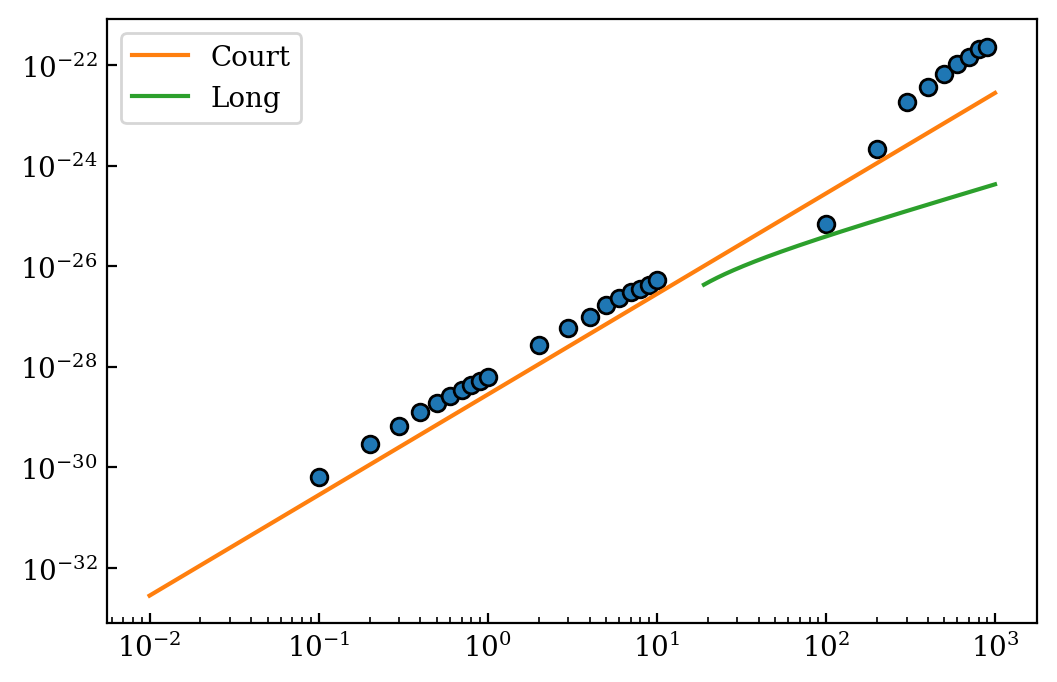

In [6]:
tt_court = np.linspace(1e-2, dt*Nt, 10000)
tt_long = np.linspace(19, dt*Nt, 10000)

plt.loglog(tau, np.mean( data, axis=0), "o")
plt.loglog(tt_court, A4_theo*tt_court**2,label=r"Court")
plt.plot(tt_long, D4_theo*tt_long-C4_theo, label=r"Long")

plt.legend()